In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Table, Column, MetaData, DateTime
from datetime import datetime, timedelta
import dateutil.relativedelta

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results  
# Calculate the date 1 year ago from the last data point in the database

# get the max date
max_date = session.query(func.max(Measurement.date)).scalar()
print(max_date)

# format the max date to be used in the calculation
format_max_date = dt.datetime.strptime(max_date,"%Y-%m-%d").date() 

# start date is 1 year prior to max date
start_date = format_max_date - dateutil.relativedelta.relativedelta(months=12)
print(start_date)

2017-08-23
2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.read_sql(session.query(Measurement).filter(Measurement.date >= start_date).group_by(Measurement.date).statement,session.bind) 

df.tail()

,id,station,date,prcp,tobs
361,2720,USC00519397,2017-08-19,0.0,79.0
362,2721,USC00519397,2017-08-20,0.0,81.0
363,2722,USC00519397,2017-08-21,0.0,81.0
364,2723,USC00519397,2017-08-22,0.0,82.0
365,2724,USC00519397,2017-08-23,0.0,81.0


In [12]:
# Sort the dataframe by date
df = df.replace('NaN', 0)

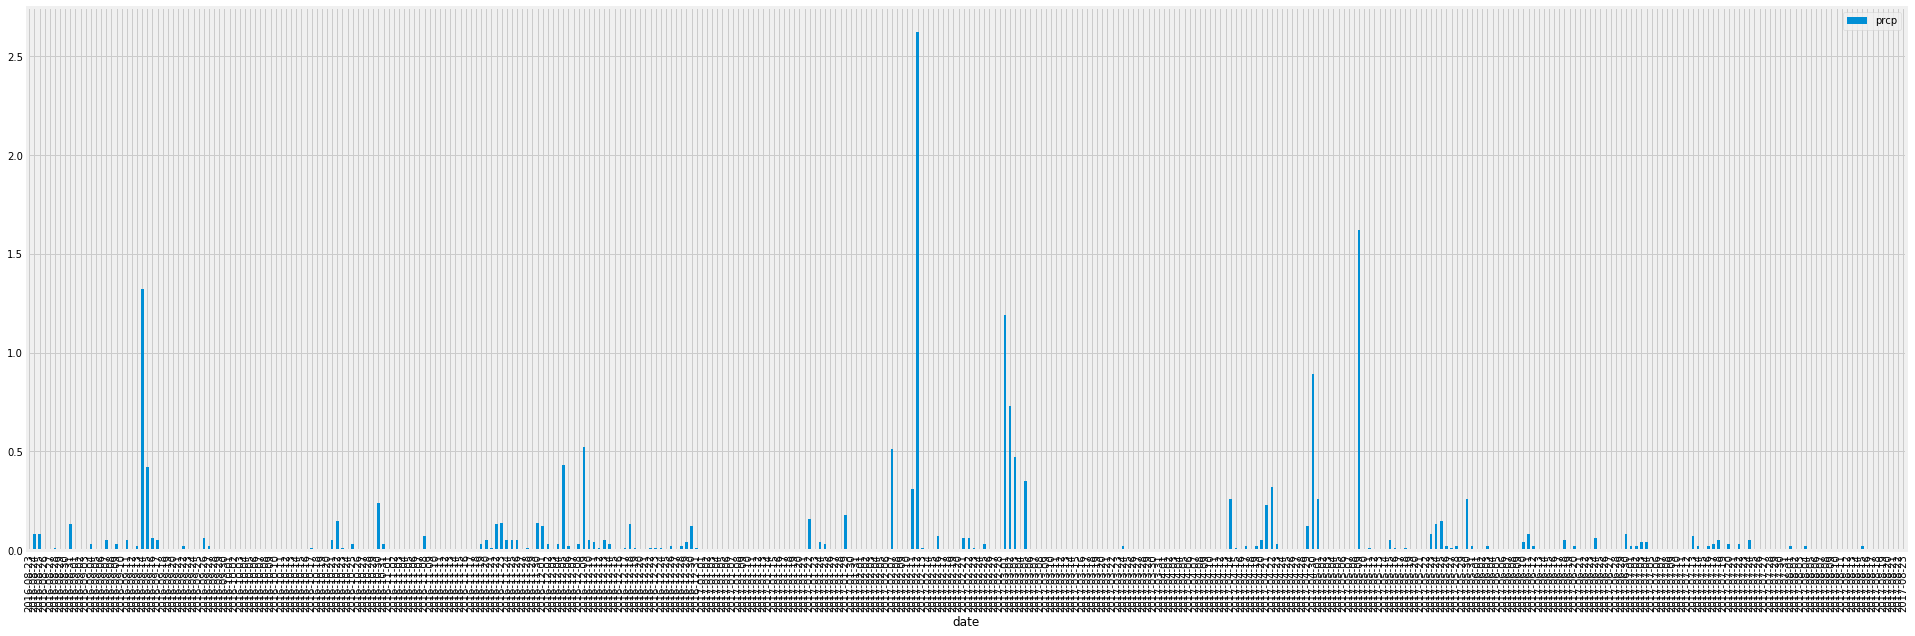

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='bar', x='date', y='prcp', figsize=(30,10))

# Save the figure
plt.savefig("Precipitation by date.png")

plt.show()

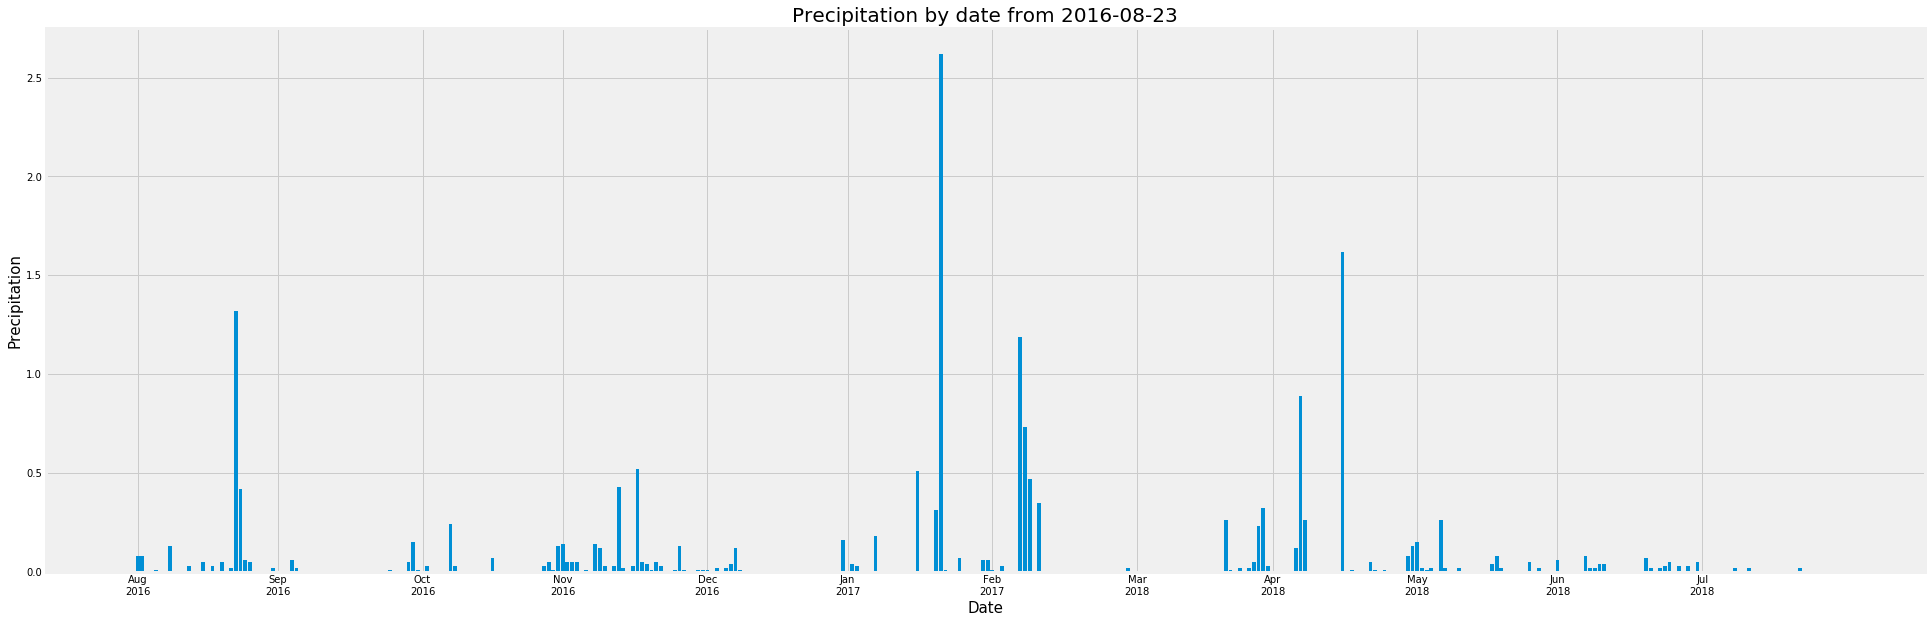

In [29]:
plt.bar(df["date"], df["prcp"])  

plt.ylabel("Precipitation", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.xticks([1, 31, 62, 92, 123, 153, 184, 215, 244, 275, 305, 336],
           ["Aug\n2016", "Sep\n2016", "Oct\n2016", "Nov\n2016", "Dec\n2016", "Jan\n2017",
            "Feb\n2017", "Mar\n2018", "Apr\n2018", "May\n2018", "Jun\n2018", "Jul\n2018"])
plt.title("Precipitation by date from " + str(start_date), fontsize=20)
plt.grid(True)
plt.rcParams["figure.figsize"] = (10,30)

# Save the figure
plt.savefig("Precipitation by date.png")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df1 = df['prcp']
stats = df1.describe()
stats

count    364.000000
mean       0.048709
std        0.204930
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: prcp, dtype: float64

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

df_station = pd.read_sql(session.query(Measurement.station, func.count(Measurement.station)).
                       group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).
                         statement,session.bind)
df_station

,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

df_active = pd.read_sql(session.query(
                func.max(Measurement.tobs), 
                func.min(Measurement.tobs), 
                func.avg(Measurement.tobs))
                .filter(Measurement.station =='USC00519281').statement, 
                session.bind)
df_active

,max_1,min_1,avg_1
0,85.0,54.0,71.663781


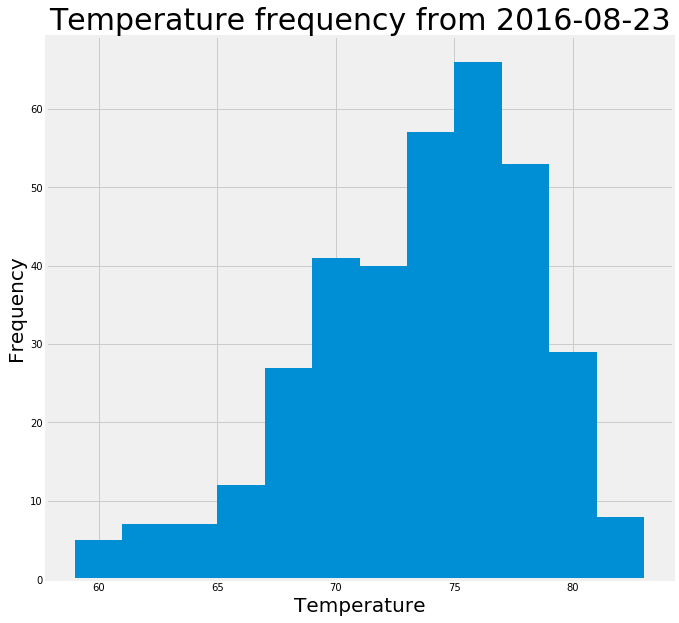

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df_temp = pd.read_sql(session.query(Measurement.tobs).filter(Measurement.date >= start_date).
                      filter(Measurement.station == 'USC00519281').statement,session.bind) 

plt.hist(df_temp['tobs'],bins=12)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Temperature", fontsize=20)
plt.title("Temperature frequency from " + str(start_date), fontsize=30)
plt.grid(True)
plt.rcParams["figure.figsize"] = (10,6)

# Save the figure
plt.savefig("Temperature frequency.png")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


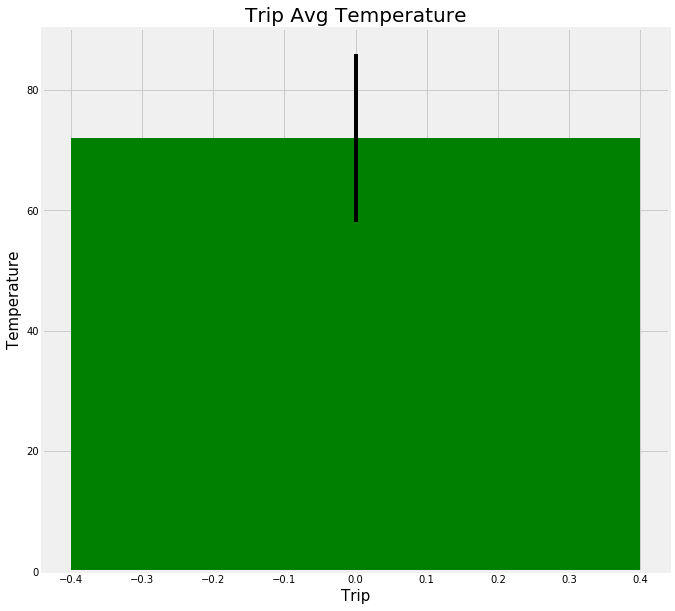

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_data = calc_temps('2017-02-28', '2017-03-05')

error_data = []

for row in trip_data:
    error_data.append(row[0])
    error_data.append(row[1])
    error_data.append(row[2])
    
plt.bar(0,error_data[1],color="green", yerr=error_data[2] - error_data[0])

plt.ylabel("Temperature", fontsize=15)
plt.xlabel("Trip", fontsize=15)
plt.title("Trip Avg Temperature", fontsize=20)
plt.grid(True)
plt.rcParams["figure.figsize"] = (6,10)

# Save the figure
plt.savefig("Trip Avg Temp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
df_rainfall = pd.read_sql(session.query(func.sum(Measurement.prcp),Measurement.station, 
                       Station.name, Station.latitude, Station.longitude, Station.elevation).
                       group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).
                       filter(Measurement.date >= '2017-02-28').filter(Measurement.date <= '2017-03-05'). 
                           filter(Measurement.station == Station.station).
                         statement,session.bind)
df_rainfall.head(9)

,sum_1,station,name,latitude,longitude,elevation
0,4.72,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,4.45,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,4.07,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,2.98,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,2.74,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,2.32,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,1.16,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
